In [1]:
#!/usr/bin/env python
import os
import numpy as np
import sys
import xarray as xr
import pygrib
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [18]:
# NetCDF4 files (commented out)

# Set pathway and filename
#path_mpi  = '/st1/cahoopes/WRF/WRFV3/test/em_real/'
#model_data = xr.open_dataset(path_mpi+'/wrfout_d03_2018-12-31_12:00:00')
#model_data  # uncomment this to see full list of variables/dimensions of xarray

# Assign one variable in data file SOWNC to script variable 
# select last index -1 in time dimension because SNOWNC is hourly accumulated 
#sn_wrf = model_data.SNOWNC[-1,:,:]
#sn_wrf.shape

(90, 96)

In [7]:
# GRIB2 files

# Set pathway and filename
hrrr_path = '/st1/cahoopes/'
endfile = 'hrrr_t00z_wrfsfcf48.grib2'
anlfile = 'hrrr_t00z_wrfsfcf24.grib2'
#path_stageiv+file #uncomment to check pathway

In [8]:
# Use pygrib to open grib file
halfgrbs = pygrib.open(hrrr_path+anlfile)
endgrbs = pygrib.open(hrrr_path+endfile)
endgrbs.read() # uncomment to read all grib information like variables/dimensions 

[1:Maximum/Composite radar reflectivity:dB (instant):lambert:atmosphere:level 0 -:fcst time 48 hrs:from 202107240000,
 2:3:3 (instant):lambert:cloudTop:level 0:fcst time 48 hrs:from 202107240000,
 3:201:201 (instant):lambert:atmosphere:level 0 -:fcst time 48 hrs:from 202107240000,
 4:Vertically-integrated liquid:kg m**-1 (instant):lambert:atmosphere:level 0 -:fcst time 48 hrs:from 202107240000,
 5:Visibility:m (instant):lambert:surface:level 0:fcst time 48 hrs:from 202107240000,
 6:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 1000 m:fcst time 48 hrs:from 202107240000,
 7:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 4000 m:fcst time 48 hrs:from 202107240000,
 8:Derived radar reflectivity:dB (instant):lambert:isothermal:level 263 K:fcst time 48 hrs:from 202107240000,
 9:Wind speed (gust):m s**-1 (instant):lambert:surface:level 0:fcst time 48 hrs:from 202107240000,
 10:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 2

In [11]:
# Select variables, assign to script variables, and any processing
endmsg = endgrbs.select(name='Total Precipitation')[0]  
halfmsg = halfgrbs.select(name='Total Precipitation')[0]
# Replace the missing values with a more robust missing value, np.nan
end_prcp_hrrr = np.where(endmsg.values.data==9999.0, np.nan, endmsg.values.data)
half_prcp_hrrr = np.where(halfmsg.values.data==9999.0, np.nan, halfmsg.values.data)
# Lats, lons should be the same for both files
lats_obs, lons_obs = endmsg.latlons()
# Combine into single file, set units to cm
# Check local dimensions
end_prcp_hrrr.shape,lats_obs.shape,lons_obs.shape
print (lons_obs)
print (lats_obs)

[[-122.719528   -122.69286132 -122.6661903  ...  -72.3430592
   -72.31638668  -72.28971849]
 [-122.72702499 -122.70035119 -122.67367305 ...  -72.33557892
   -72.30889927  -72.28222397]
 [-122.73452632 -122.7078454  -122.68116014 ...  -72.3280943
   -72.30140753  -72.2747251 ]
 ...
 [-134.0648096  -134.02828423 -133.99174671 ...  -61.02092594
   -60.9843842   -60.94785462]
 [-134.08013858 -134.04360126 -134.00705178 ...  -61.00562502
   -60.96907132  -60.93252978]
 [-134.09547973 -134.05893046 -134.02236901 ...  -60.99031194
   -60.95374627  -60.91719277]]
[[21.138123   21.14511004 21.1520901  ... 21.1545089  21.14753125
  21.14054663]
 [21.16299459 21.1699845  21.17696744 ... 21.17938723 21.1724067
  21.16541921]
 [21.18786863 21.19486142 21.20184723 ... 21.20426802 21.19728462
  21.19029425]
 ...
 [47.78955926 47.799849   47.81012868 ... 47.81369093 47.80341474
  47.79312849]
 [47.81409316 47.82438621 47.8346692  ... 47.83823259 47.8279531
  47.81766354]
 [47.8386235  47.84891986 47.8

In [15]:
# Create xarray for obs data for efficient lat/lon subsetting
epr_hrrr = xr.DataArray(data=end_prcp_hrrr,
                  dims=["x", "y"],
                  coords=dict(lon=(["x", "y"], lons_obs),
                              lat=(["x", "y"], lats_obs)),
                  attrs=dict(description="Total HRRR Precip",
                             units="mm")                      )
hpr_hrrr = xr.DataArray(data=half_prcp_hrrr,
                  dims=["x", "y"],
                  coords=dict(lon=(["x", "y"], lons_obs),
                              lat=(["x", "y"], lats_obs)),
                  attrs=dict(description="Total HRRR Precip",
                             units="mm")                      ) 
epr_hrrr.shape,hpr_hrrr.shape

((1059, 1799), (1059, 1799))

In [17]:
# Crop both files to Southeast Arizona co-ordinates (inner WRF domain)
# Define SE AZ co-ordinates
az_hrrrcood = [-115, -108, 31.0, 37.5] 
#az_gfscood = [248, 252, 31.0, 33.75]
# Crop model data
az_epr_hrrr = epr_hrrr.where((az_hrrrcood[0] <= epr_hrrr.lon) & (epr_hrrr.lon < az_hrrrcood[1])
                      & (az_hrrrcood[2] <= epr_hrrr.lat) & (epr_hrrr.lat < az_hrrrcood[3]), drop=True)
az_hpr_hrrr = hpr_hrrr.where((az_hrrrcood[0] <= hpr_hrrr.lon) & (hpr_hrrr.lon < az_hrrrcood[1])
                      & (az_hrrrcood[2] <= hpr_hrrr.lat) & (hpr_hrrr.lat < az_hrrrcood[3]), drop=True)

az_epr_hrrr.shape,az_hpr_hrrr.shape

((271, 249), (271, 249))

/st1/cahoopes/miniconda3/envs/pybootcamp/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/st1/cahoopes/miniconda3/envs/pybootcamp/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


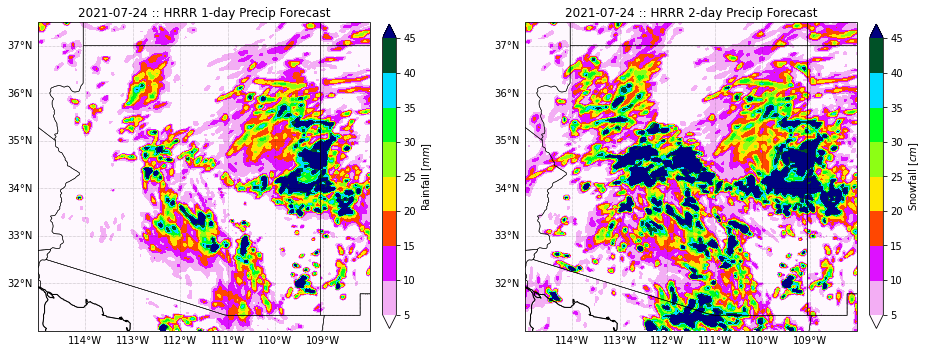

In [20]:
# Panel plot of WRF vs GFS

# set the projection for the map
projection = ccrs.PlateCarree()

# start a figure named fig, set axis name, dimesions of fig, and projection
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8),
                       subplot_kw={'projection': projection})

## AX1
# set levels for colorbar
levels = np.arange(5,50,5)
# plot filled contours (contourf) onto ax1
cs = ax1.contourf(az_hpr_hrrr.lon.data, az_hpr_hrrr.lat.data, az_hpr_hrrr.data,
                  transform=projection,
                  cmap='gist_ncar_r',levels=levels,
                  extend='both')

# add color bar
labels = [str(item) for item in levels]
cax,kw = matplotlib.colorbar.make_axes(ax1,ticks=levels,location='right',pad=0.03,shrink=0.7)
cbar = fig.colorbar(cs,cax=cax,**kw)
cbar.ax.set_yticklabels(labels)
cbar.set_label('Rainfall $[mm]$',size=10)

# crop extent of map to lat/lon of data
ax1.set_extent(az_hrrrcood)

# add lat lon gridline
gl = ax1.gridlines(draw_labels=True,
             xlocs=np.arange(-180, 180, 1.),
             ylocs=np.arange(-90, 90, 1.),
             linewidth=0.5, color='k', alpha=0.5, linestyle=':')
gl.xlabels_top = None
gl.ylabels_right = None
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# set plot title
ax1.set_title('2021-07-24 :: HRRR 1-day Precip Forecast', loc='center',pad=5,fontsize=12) 

# add map features to plot
#ax1.add_feature(cartopy.feature.LAND)
#ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.COASTLINE)
ax1.add_feature(cartopy.feature.STATES,linewidth=0.5)
ax1.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.5)

## AX2
# plot filled contours (contourf) onto ax2
cs = ax2.contourf(az_epr_hrrr.lon, az_epr_hrrr.lat, az_epr_hrrr,
                  transform=projection,
                  cmap='gist_ncar_r',levels=levels,
                  extend='both')

# add color bar
labels = [str(item) for item in levels]
cax,kw = matplotlib.colorbar.make_axes(ax2,ticks=levels,location='right',pad=0.03,shrink=0.7)
cbar = fig.colorbar(cs,cax=cax,**kw)
cbar.ax.set_yticklabels(labels)
cbar.set_label('Snowfall $[cm]$',size=10)

# crop extent of map to lat/lon of data
ax2.set_extent(az_hrrrcood)

# add lat lon gridline
gl = ax2.gridlines(draw_labels=True,
             xlocs=np.arange(-180, 180, 1.),
             ylocs=np.arange(-90, 90, 1.),
             linewidth=0.5, color='k', alpha=0.5, linestyle=':')
gl.xlabels_top = None
gl.ylabels_right = None
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# set plot title
ax2.set_title('2021-07-24 :: HRRR 2-day Precip Forecast', loc='center',pad=5,fontsize=12) 

# add map features to plot
#ax2.add_feature(cartopy.feature.LAND)
#ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.COASTLINE)
ax2.add_feature(cartopy.feature.STATES,linewidth=0.5)
ax2.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.5)

# save plot to same directory as script
plotfile = 'July_2021_Monsoon_Forecast.png'
sf = fig.savefig(plotfile, dpi=300, bbox_inches='tight')
plt.show()